In [34]:
import pandas as pd
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

In [35]:
df_carpol_1303 = pd.read_csv('data/carpol_1303/1303_1minDataSet.csv')
df_carpol_1304 = pd.read_csv('data/carpol_1304/1304_1minDataSet.csv')
df_ref = pd.read_csv('data/RefInstrument_15minDataSet.csv')

In [36]:
df_ref.head()

,date,H2S(ppb),SO2(ppb)
0,2016-05-20 00:15:00,NaN,0.0
1,2016-05-20 00:30:00,0.1,0.4
2,2016-05-20 00:45:00,0.0,0.7
3,2016-05-20 01:00:00,0.0,0.4
4,2016-05-20 01:15:00,NaN,0.0


In [37]:
def align_df(df1, df2):
    if df1.iloc[0, 0] > df2.iloc[0, 0]:
        return align_df(df2, df1)
    while df1.iloc[0, 0] < df2.iloc[0, 0]:
        df1 = df1.iloc[1:]
    while df2.iloc[0, 0] < df1.iloc[0, 0]:
        df2 = df2.iloc[1:]
    return df1, df2

df_ref_1303, df_carpol_1303 = align_df(df_carpol_1303, df_ref)
df_ref_1304, df_carpol_1304 = align_df(df_carpol_1304, df_ref)

print(df_carpol_1303.head())
print(df_carpol_1304.head())

                   date  H2S(ppb)  Temperature(°C)  RelativeHumidity(%)
8   2016-05-23 08:15:00        14               24                   42
9   2016-05-23 08:16:00        13               24                   42
10  2016-05-23 08:17:00        14               24                   42
11  2016-05-23 08:18:00        13               24                   42
12  2016-05-23 08:19:00        14               24                   42
                   date  H2S(ppb)  Temperature(°C)  RelativeHumidity(%)
10  2016-05-23 08:15:00        10               24                   42
11  2016-05-23 08:16:00         8               24                   42
12  2016-05-23 08:17:00         8               24                   42
13  2016-05-23 08:18:00         8               24                   42
14  2016-05-23 08:19:00        10               24                   42


In [38]:
def create_1min_data_set(df_carpol, df_ref, captor):
    if df_carpol.iloc[0, 0] != df_ref.iloc[0, 0]:
        df_carpol, df_ref = align_df(df_carpol, df_ref)
    df = pd.read_csv(os.path.join('data', 'Patm_15minDataSet.csv'))
    pressures = df.set_index('date').T
    i = 0
    out_df = pd.DataFrame(columns=['date','pressure', 'temperature','humidity','so2', 'h2s', 'h2s_ref','captor'])
    df_ref = df_ref.iloc[1:]
    while len(df_carpol) > 0 and len(df_ref) > 0:
        date, h2s_ref, so2 = df_ref.iloc[0, 0], df_ref.iloc[0, 1], df_ref.iloc[0, 2]
        temperature, humidity = df_carpol.iloc[0, 2], df_carpol.iloc[0, 3]
        h2s, temperature, humidity = [], [], []
        df_ref = df_ref.iloc[1:]
        while df_carpol.iloc[0, 0] < date:
            h2s.append(df_carpol.iloc[0, 1])
            if df_carpol.iloc[0, 2]:
                temperature.append(df_carpol.iloc[0, 2])
            if df_carpol.iloc[0, 3]:
                humidity.append(df_carpol.iloc[0, 3])
            df_carpol = df_carpol.iloc[1:]
            if len(df_carpol) == 0:
                break
        if len(h2s) != 15:
            continue
        h2s = np.array(h2s)
        if date not in pressures:
            pressure = None

        out_df.loc[i] = [date, pressures[date][0], np.mean(temperature), np.mean(humidity), \
                         so2, h2s, h2s_ref, captor]
        i += 1
    print(out_df.head())
    return out_df

In [55]:
out_df_1003 = create_1min_data_set(df_carpol_1303, df_ref_1303, '1303')
out_df_1004 = create_1min_data_set(df_carpol_1304, df_ref_1304, '1304')

                  date pressure  temperature  humidity  so2  \
0  2016-05-23 08:30:00     1017         24.0      42.0  0.0   
1  2016-05-23 08:45:00     1017         24.0      42.0  0.0   
2  2016-05-23 09:00:00     1017         24.0      42.0  0.0   
3  2016-05-23 09:15:00     1017         24.0      42.0  0.0   
4  2016-05-23 09:30:00     1017         24.0      42.0  0.0   

                                                 h2s  h2s_ref captor  
0  [14, 13, 14, 13, 14, 13, 14, 13, 14, 14, 16, 1...      NaN   1303  
1  [13, 14, 16, 16, 17, 16, 14, 16, 15, 16, 14, 1...      NaN   1303  
2  [17, 13, 14, 13, 15, 15, 15, 16, 15, 14, 16, 1...      NaN   1303  
3  [13, 13, 15, 15, 15, 15, 15, 16, 16, 15, 16, 1...      0.0   1303  
4  [15, 16, 15, 14, 16, 15, 14, 13, 14, 16, 13, 1...      NaN   1303  
                  date pressure  temperature  humidity  so2  \
0  2016-05-23 08:30:00     1017         24.0      42.0  0.0   
1  2016-05-23 08:45:00     1017         24.0      42.0  0.0   
2  201

In [40]:
print(len(out_df_1003), len(out_df_1004))

3273 12541


In [56]:
tmp_df = out_df_1003.append(out_df_1004)
print(tmp_df.head())
tmp_df.to_pickle('data/data_1min_vectors.pkl')

                  date pressure  temperature  humidity  so2  \
0  2016-05-23 08:30:00     1017         24.0      42.0  0.0   
1  2016-05-23 08:45:00     1017         24.0      42.0  0.0   
2  2016-05-23 09:00:00     1017         24.0      42.0  0.0   
3  2016-05-23 09:15:00     1017         24.0      42.0  0.0   
4  2016-05-23 09:30:00     1017         24.0      42.0  0.0   

                                                 h2s  h2s_ref captor  
0  [14, 13, 14, 13, 14, 13, 14, 13, 14, 14, 16, 1...      NaN   1303  
1  [13, 14, 16, 16, 17, 16, 14, 16, 15, 16, 14, 1...      NaN   1303  
2  [17, 13, 14, 13, 15, 15, 15, 16, 15, 14, 16, 1...      NaN   1303  
3  [13, 13, 15, 15, 15, 15, 15, 16, 16, 15, 16, 1...      0.0   1303  
4  [15, 16, 15, 14, 16, 15, 14, 13, 14, 16, 13, 1...      NaN   1303  


In [57]:
# Chargement et normalisation des données
df = pd.read_pickle('data/data_1min_vectors.pkl')
data = df[['pressure', 'temperature', 'humidity', 'so2', 'h2s_ref']]
df[['pressure', 'temperature', 'humidity', 'so2', 'h2s_ref']] =  data.apply(pd.to_numeric, errors="coerce").apply(lambda x: (x - np.mean(x)) / (np.std(x)))
df = df[pd.notnull(df).all(axis=1)] # On ne garde que les données sans NaN etc..
data = df[['h2s']]

In [58]:
df.head(25)
df.shape

(8651, 8)

In [59]:
data = df['h2s']
sum = []
for i in range(len(data)):
    sum += [n for n in data.iloc[i]]
mean = np.mean(sum)
std = np.std(sum)

df[['h2s']] = data.apply(lambda x: [(n-mean)/std for n in x])
print(df.shape)
df.head()

(8651, 8)


,date,pressure,temperature,humidity,so2,h2s,h2s_ref,captor
3,2016-05-23 09:15:00,0.092016,1.005873,-1.620684,-0.255663,"[1.48270099942, 1.48270099942, 1.81550249525, ...",-0.623923,1303
8,2016-05-23 10:30:00,0.240091,1.005873,-1.687291,-0.255663,"[1.81550249525, 1.81550249525, 1.48270099942, ...",-0.623923,1303
19,2016-05-23 13:15:00,0.388166,1.005873,-1.820506,-0.255663,"[1.81550249525, 1.98190324317, 1.64910174734, ...",-0.623923,1303
24,2016-05-23 14:30:00,0.388166,1.005873,-1.820506,-0.255663,"[1.64910174734, 1.98190324317, 1.64910174734, ...",-0.492004,1303
30,2016-05-23 16:00:00,0.388166,1.005873,-1.887113,-0.255663,"[1.64910174734, 1.48270099942, 1.64910174734, ...",-0.623923,1303


In [60]:
df = pd.concat([df, df['h2s'].apply(pd.Series)], axis=1)
print(df.shape)
df.to_pickle("data/data_1min.pkl")
df.head()


(8651, 23)


,date,pressure,temperature,humidity,so2,h2s,h2s_ref,captor,0,1,...,5,6,7,8,9,10,11,12,13,14
3,2016-05-23 09:15:00,0.092016,1.005873,-1.620684,-0.255663,"[1.48270099942, 1.48270099942, 1.81550249525, ...",-0.623923,1303,1.482701,1.482701,...,1.815502,1.815502,1.981903,1.981903,1.815502,1.981903,1.815502,1.649102,1.815502,1.815502
8,2016-05-23 10:30:00,0.240091,1.005873,-1.687291,-0.255663,"[1.81550249525, 1.81550249525, 1.48270099942, ...",-0.623923,1303,1.815502,1.815502,...,1.649102,1.981903,1.482701,1.649102,1.482701,1.316300,1.649102,1.981903,1.316300,1.815502
19,2016-05-23 13:15:00,0.388166,1.005873,-1.820506,-0.255663,"[1.81550249525, 1.98190324317, 1.64910174734, ...",-0.623923,1303,1.815502,1.981903,...,1.815502,1.649102,1.981903,1.482701,1.815502,1.482701,1.981903,1.815502,1.482701,1.815502
24,2016-05-23 14:30:00,0.388166,1.005873,-1.820506,-0.255663,"[1.64910174734, 1.98190324317, 1.64910174734, ...",-0.492004,1303,1.649102,1.981903,...,1.649102,1.649102,1.649102,1.649102,1.981903,1.981903,1.815502,1.815502,1.815502,1.815502
30,2016-05-23 16:00:00,0.388166,1.005873,-1.887113,-0.255663,"[1.64910174734, 1.48270099942, 1.64910174734, ...",-0.623923,1303,1.649102,1.482701,...,1.815502,2.314705,1.649102,1.649102,1.815502,1.815502,1.149900,1.981903,1.815502,1.482701


In [7]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return np.array(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,\
                        'pressure', 'temperature', 'humidity', 'so2']]), np.array(df['h2s_ref'])


In [8]:
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

In [32]:
def baseline_model(dense_size, input_dim, loss_function, optimizer):
    # create model
    model = Sequential()
    model.add(Dense(dense_size, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=loss_function, optimizer=optimizer)
    model.summary()
    return model
model = baseline_model(512, len(X_train[0, :]), 'mean_squared_error', 'adagrad')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               10240     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist = model.fit(X_train, y_train, batch_size=5, epochs=200, validation_data=(X_valid, y_valid), callbacks=[])

Train on 4325 samples, validate on 2163 samples
Epoch 1/200
4325/4325 [==============================] - 2s - loss: 0.2494 - val_loss: 0.3510
Epoch 2/200
4325/4325 [==============================] - 1s - loss: 0.1610 - val_loss: 0.3554
Epoch 3/200
4325/4325 [==============================] - 1s - loss: 0.1544 - val_loss: 0.3606
Epoch 4/200
4325/4325 [==============================] - 1s - loss: 0.1557 - val_loss: 0.3509
Epoch 5/200
4325/4325 [==============================] - 1s - loss: 0.1513 - val_loss: 0.3527
Epoch 6/200
4325/4325 [==============================] - 1s - loss: 0.1474 - val_loss: 0.3533
Epoch 7/200
4325/4325 [==============================] - 1s - loss: 0.1433 - val_loss: 0.3439
Epoch 8/200
4325/4325 [==============================] - 1s - loss: 0.1410 - val_loss: 0.3315
Epoch 9/200
4325/4325 [==============================] - 1s - loss: 0.1352 - val_loss: 0.3331
Epoch 10/200
4325/4325 [==============================] - 1s - loss: 0.1354 - val_loss: 0.3386
Epoch 11/20

4325/4325 [==============================] - 1s - loss: 0.0736 - val_loss: 0.3572
Epoch 172/200
4325/4325 [==============================] - 1s - loss: 0.0741 - val_loss: 0.3616
Epoch 173/200
4325/4325 [==============================] - 1s - loss: 0.0731 - val_loss: 0.3588
Epoch 174/200
4325/4325 [==============================] - 1s - loss: 0.0730 - val_loss: 0.3640
Epoch 175/200
4325/4325 [==============================] - 1s - loss: 0.0727 - val_loss: 0.3692
Epoch 176/200
4325/4325 [==============================] - 1s - loss: 0.0724 - val_loss: 0.3662
Epoch 177/200
4325/4325 [==============================] - 1s - loss: 0.0728 - val_loss: 0.3620
Epoch 178/200
4325/4325 [==============================] - 1s - loss: 0.0720 - val_loss: 0.3589
Epoch 179/200
4325/4325 [==============================] - 1s - loss: 0.0720 - val_loss: 0.3565
Epoch 180/200
4325/4325 [==============================] - 1s - loss: 0.0722 - val_loss: 0.3575
Epoch 181/200
4325/4325 [=============================

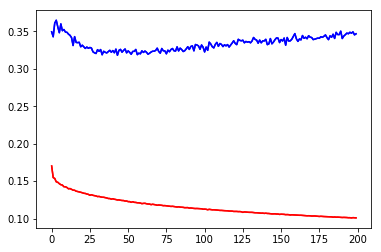

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], 'r-')
plt.plot(hist.history['val_loss'], 'b-')
plt.show()

In [21]:
y_pred = model.predict(X_test)

In [22]:
tolerances = np.linspace(0, 2, 10)
acc = []
for tol in tolerances:
    y_tol = tol*y_train.flatten()
    accur = np.sum(np.abs(y_pred.flatten() - y_test.flatten()) <= tol) / len(y_test)
    acc.append(accur)

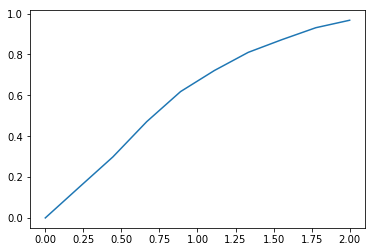

In [23]:
plt.plot(tolerances, acc)
plt.show()

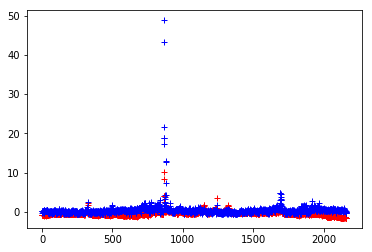

In [27]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

plt.plot(y_pred, 'r+')
plt.plot(y_test, 'b+')
plt.show()

In [28]:
y_test

array([-0.22816429,  0.16759455,  0.29951416, ..., -0.22816429,
       -0.09624467,  0.16759455])